In [7]:
!git clone https://github.com/jmnwong/NSL-KDD-Dataset.git

fatal: destination path 'NSL-KDD-Dataset' already exists and is not an empty directory.


In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [9]:
random_state = 12
tf.random.set_seed(random_state)
np.random.seed(random_state)

In [10]:
train = pd.read_csv('NSL-KDD-Dataset/KDDTrain+.txt', header=None)
test = pd.read_csv('NSL-KDD-Dataset/KDDTest+.txt', header=None)

In [11]:
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,25,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,8,1.0,1.0,0.0,0.0,0.06,0.05,0.00,255,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20


In [12]:
train.describe()

,0,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.0,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,0.001342,0.001103,0.302192,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.107555,27.737888,0.284485,0.282485,0.119958,0.121183,0.660928,0.063053,0.097322,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,19.504060
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,0.036603,0.045154,24.399618,0.483935,0.022181,0.099370,0.0,0.002817,0.096612,114.508607,72.635840,0.446456,0.447022,0.320436,0.323647,0.439623,0.180314,0.259830,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,2.291503
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [13]:
encoder = OneHotEncoder(handle_unknown='ignore')
scaler = MinMaxScaler()

In [14]:
def preprocess(df, is_fit=True):
  # chuyển normal thành 1 và các lớp khác thành 0
  label = np.where(df[41] == 'normal', 'normal', 'abnormal')

  # loại bỏ cột dữ liệu không cần thiết
  df.drop([41, 42], axis=1)

  # chia dữ liệu ra số, chữ để tiện xử lý
  numerical_data = df.select_dtypes(exclude='object').values
  categorical_data = df.select_dtypes(include='object').values

  # chỉ fit với dữ liệu train
  if is_fit:
    encoder.fit(categorical_data)

  # chuyển từ dữ liệu chữ sang onehot
  categorical_data = encoder.transform(categorical_data).toarray()

  # nối dữ liệu số và onehot lại
  data = np.concatenate([numerical_data, categorical_data], axis=1)

  # chỉ fit với dữ liệu train
  if is_fit:
    scaler.fit(data)
  
  # dữ liệu chuẩn hóa về dạng [0, 1]
  data = scaler.transform(data)
  
  return dict(data=data, label=label)

In [15]:
# xử lý dữ liệu
train = preprocess(train, True)
test = preprocess(test, False)

In [23]:
train['data'].shape, test['data'].shape

((125973, 146), (22544, 146))

In [16]:
class Autoencoder(keras.Model):
  def __init__(self, input_dim):
    super(Autoencoder, self).__init__()
    self.encoder = keras.Sequential([
      keras.layers.Dense(64, activation='tanh'),
      keras.layers.Dense(32, activation='tanh'),
      keras.layers.Dense(16, activation='tanh'),
      keras.layers.Dense(8, activation='tanh')
    ])
    self.decoder = keras.Sequential([
      keras.layers.Dense(16, activation='tanh'),
      keras.layers.Dense(32, activation='tanh'),
      keras.layers.Dense(64, activation='tanh'),
      keras.layers.Dense(input_dim, activation='sigmoid'),
    ])

  def call(self, x):
    code = self.encoder(x)
    r = self.decoder(code)
    return r

  def get_reconstruction_error(self, x):
    r = self.predict(x)
    return keras.metrics.mean_squared_error(x, r)

  def predict_class(self, x, threshold):
    reconstruction_error = self.get_reconstruction_error(x)
    return np.where(reconstruction_error <= threshold, 'normal', 'abnormal')

In [17]:
# chia dữ liệu
train_normal = train['data'][train['label'] == 'normal']
train_abnormal = train['data'][train['label'] == 'abnormal']

test_normal = test['data'][test['label'] == 'normal']
test_abnormal = test['data'][test['label'] == 'abnormal']

In [18]:
model = Autoencoder(train_normal.shape[1])
optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.MeanSquaredError()
model.compile(optimizer, loss_fn)

In [24]:
model.fit(train_normal, train_normal, batch_size=64, epochs=100)

Epoch 1/100
1053/1053 [==============================] - 4s 4ms/step - loss: 8.7605e-04
Epoch 2/100
1053/1053 [==============================] - 4s 4ms/step - loss: 8.0808e-04
Epoch 3/100
1053/1053 [==============================] - 4s 4ms/step - loss: 7.4478e-04
Epoch 4/100
1053/1053 [==============================] - 4s 4ms/step - loss: 6.8760e-04
Epoch 5/100
1053/1053 [==============================] - 4s 4ms/step - loss: 6.4568e-04
Epoch 6/100
1053/1053 [==============================] - 4s 4ms/step - loss: 6.1912e-04
Epoch 7/100
1053/1053 [==============================] - 4s 4ms/step - loss: 5.9678e-04
Epoch 8/100
1053/1053 [==============================] - 4s 4ms/step - loss: 5.7718e-04
Epoch 9/100
1053/1053 [==============================] - 4s 4ms/step - loss: 5.6285e-04
Epoch 10/100
1053/1053 [==============================] - 4s 4ms/step - loss: 5.4646e-04
Epoch 11/100
1053/1053 [==============================] - 4s 4ms/step - loss: 5.3034e-04
Epoch 12/100
1053/1053 [======

In [25]:
# tính độ lỗi tái tạo cho tất cả các tập dữ liệu

train_normal_re = model.get_reconstruction_error(train_normal)
train_abnormal_re = model.get_reconstruction_error(train_abnormal)

test_normal_re = model.get_reconstruction_error(test_normal)
test_abnormal_re = model.get_reconstruction_error(test_abnormal)

In [26]:
# tìm ngưỡng alpha từ tập train
alpha = 0.5
threshold = np.concatenate([train_normal_re, train_abnormal_re]).mean() * alpha
print('Ngưỡng vừa tìm được từ tập train:', threshold)

Ngưỡng vừa tìm được từ tập train: 0.012324278242886066


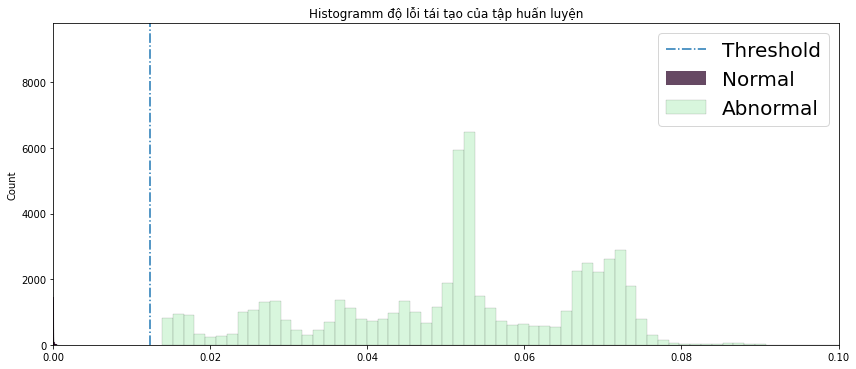

In [27]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=train_normal_re, label='Normal', kde=False, ax=ax, color='#330C2F')
sns.histplot(data=train_abnormal_re, label='Abnormal', kde=False, ax=ax, color='#CBF3D2')
ax.axvline(threshold, ls='-.', label='Threshold')
ax.legend(loc='best', fontsize=20)
ax.set_xlim([0, 0.1])
fig.tight_layout()
plt.title('Histogramm độ lỗi tái tạo của tập huấn luyện')
plt.show()

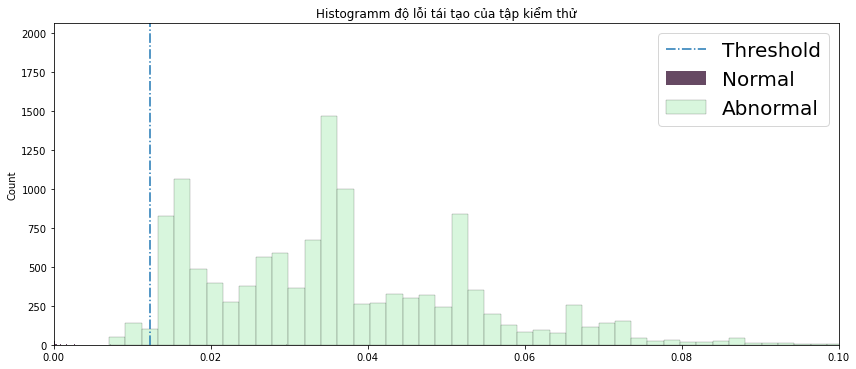

In [28]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=test_normal_re, label='Normal', kde=False, ax=ax, color='#330C2F')
sns.histplot(data=test_abnormal_re, label='Abnormal', kde=False, ax=ax, color='#CBF3D2')
ax.axvline(threshold, ls='-.', label='Threshold')
ax.legend(loc='best', fontsize=20)
ax.set_xlim([0, 0.1])
fig.tight_layout()
plt.title('Histogramm độ lỗi tái tạo của tập kiểm thử')
plt.show()

In [29]:
train_label_predict = model.predict_class(train['data'], threshold)
print('Độ chính xác tập huấn luyện', end=': ')
accuracy_score(train['label'], train_label_predict)

Độ chính xác tập huấn luyện: 

0.9978169925301453

In [30]:
test_label_predict = model.predict_class(test['data'], threshold)
print('Độ chính xác tập kiểm thử', end=': ')
accuracy_score(test['label'], test_label_predict)

Độ chính xác tập kiểm thử: 

0.9633161816891412

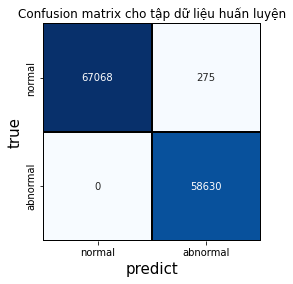

In [71]:
cfx_train = confusion_matrix(train['label'], train_label_predict, labels=['normal', 'abnormal'])
cfx_train = pd.DataFrame(cfx_train, columns=['normal', 'abnormal'], index=['normal', 'abnormal'])
sns.heatmap(cfx_train, fmt='.0f', annot=True, cbar=False, square=True, cmap='Blues', linecolor='black', linewidths=.3)
plt.xlabel('predict', fontsize=15)
plt.ylabel('true', fontsize=15)
plt.title('Confusion matrix cho tập dữ liệu huấn luyện')
plt.show()

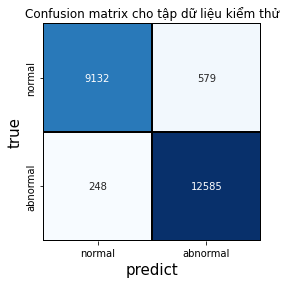

In [72]:
cfx_test = confusion_matrix(test['label'], test_label_predict, labels=['normal', 'abnormal'])
cfx_test = pd.DataFrame(cfx_test, columns=['normal', 'abnormal'], index=['normal', 'abnormal'])
sns.heatmap(cfx_test, fmt='.0f', annot=True, cbar=False, square=True, cmap='Blues', linecolor='black', linewidths=.3)
plt.xlabel('predict', fontsize=15)
plt.ylabel('true', fontsize=15)
plt.title('Confusion matrix cho tập dữ liệu kiểm thử')
plt.show()